In [3]:
from nanocontrol import nanocontrol, controller
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import pandas as pd
import json
import os

In [2]:
controller = controller()
nc = controller.ncs['1']

In [3]:
def sweep(l, u, stepsize):
    hysteresis = pd.DataFrame(columns=['finestep', 'ca_0', 'cd_0', 'ca_1', 'cd_1', 'ca_2', 'cd_2', 'ca_3', 'cd_3', 'ca_4', 'cd_4', 'ca_5', 'cd_5', 'ca_mean', 'cd_mean'])
    hysteresis['finestep'] = range(l, u, stepsize)
    for index, row in tqdm(hysteresis.iterrows(), total=len(hysteresis)):
        nc.setFinePos16Bit('C', int(row['finestep']))
        hysteresis.at[index, 'ca_0'] = int(nc.readCounter()['C'])
        hysteresis.at[index, 'ca_1'] = int(nc.readCounter()['C'])
        hysteresis.at[index, 'ca_2'] = int(nc.readCounter()['C'])
        hysteresis.at[index, 'ca_3'] = int(nc.readCounter()['C'])
        hysteresis.at[index, 'ca_4'] = int(nc.readCounter()['C'])
        hysteresis.at[index, 'ca_5'] = int(nc.readCounter()['C'])
    hysteresis['ca_mean'] = hysteresis[['ca_0', 'ca_1', 'ca_2', 'ca_3', 'ca_4', 'ca_5']].mean(axis=1)

    # iterate backwards
    for index, row in tqdm(hysteresis.iloc[::-1].iterrows(), total=len(hysteresis)):
        nc.setFinePos16Bit('C', int(row['finestep']))
        hysteresis.at[index, 'cd_0'] = int(nc.readCounter()['C'])
        hysteresis.at[index, 'cd_1'] = int(nc.readCounter()['C'])
        hysteresis.at[index, 'cd_2'] = int(nc.readCounter()['C'])
        hysteresis.at[index, 'cd_3'] = int(nc.readCounter()['C'])
        hysteresis.at[index, 'cd_4'] = int(nc.readCounter()['C'])
        hysteresis.at[index, 'cd_5'] = int(nc.readCounter()['C'])
    hysteresis['cd_mean'] = hysteresis[['cd_0', 'cd_1', 'cd_2', 'cd_3', 'cd_4', 'cd_5']].mean(axis=1)
    return hysteresis
def chill(pos, seconds):
    nc.setFinePosVoltage('A', 0)
    nc.setFinePosVoltage('B', 0)
    nc.setFinePos16Bit('C', pos)
    nc.setFinePosVoltage('D', 0)
    time.sleep(seconds)
def reset(pos, seconds):
    nc.setFinePos16Bit('A', 0)
    nc.setFinePos16Bit('B', 0)
    nc.setFinePos16Bit('C', pos)
    nc.setFinePos16Bit('D', 0)
    time.sleep(seconds)
    nc.resetCoarseCounter()
    nc.resetCounter()

#### Measure Hysteresis for different step sizes

In [5]:
lower_bound = -np.power(2, 15)
upper_bound = np.power(2, 15) - 1
stepsize = np.power(2, 2)
reset(lower_bound, 60)
for i in range(2, 10):
    stepsize = np.power(2, i)
    print(f'Stepsize: {stepsize}')
    chill(lower_bound, 60)
    hysteresis = sweep(lower_bound, upper_bound, stepsize)
    hysteresis.to_csv(f'../dat/hysteresis/fr_{stepsize}.csv')

Stepsize: 4


100%|██████████| 16384/16384 [30:32<00:00,  8.94it/s]


Stepsize: 8


100%|██████████| 8192/8192 [15:16<00:00,  8.94it/s]


Stepsize: 16


100%|██████████| 4096/4096 [07:38<00:00,  8.94it/s]


Stepsize: 32


100%|██████████| 2048/2048 [03:49<00:00,  8.94it/s]


Stepsize: 64


100%|██████████| 1024/1024 [01:54<00:00,  8.94it/s]


Stepsize: 128


100%|██████████| 512/512 [00:57<00:00,  8.94it/s]


Stepsize: 256


100%|██████████| 256/256 [00:28<00:00,  8.94it/s]


Stepsize: 512


100%|██████████| 128/128 [00:14<00:00,  8.94it/s]


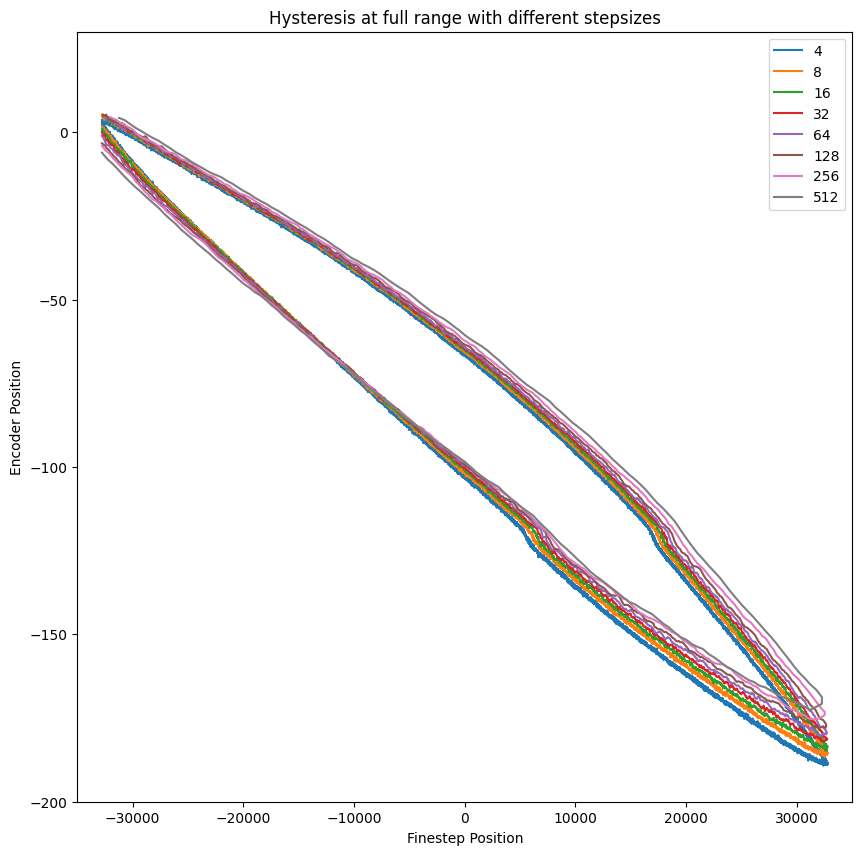

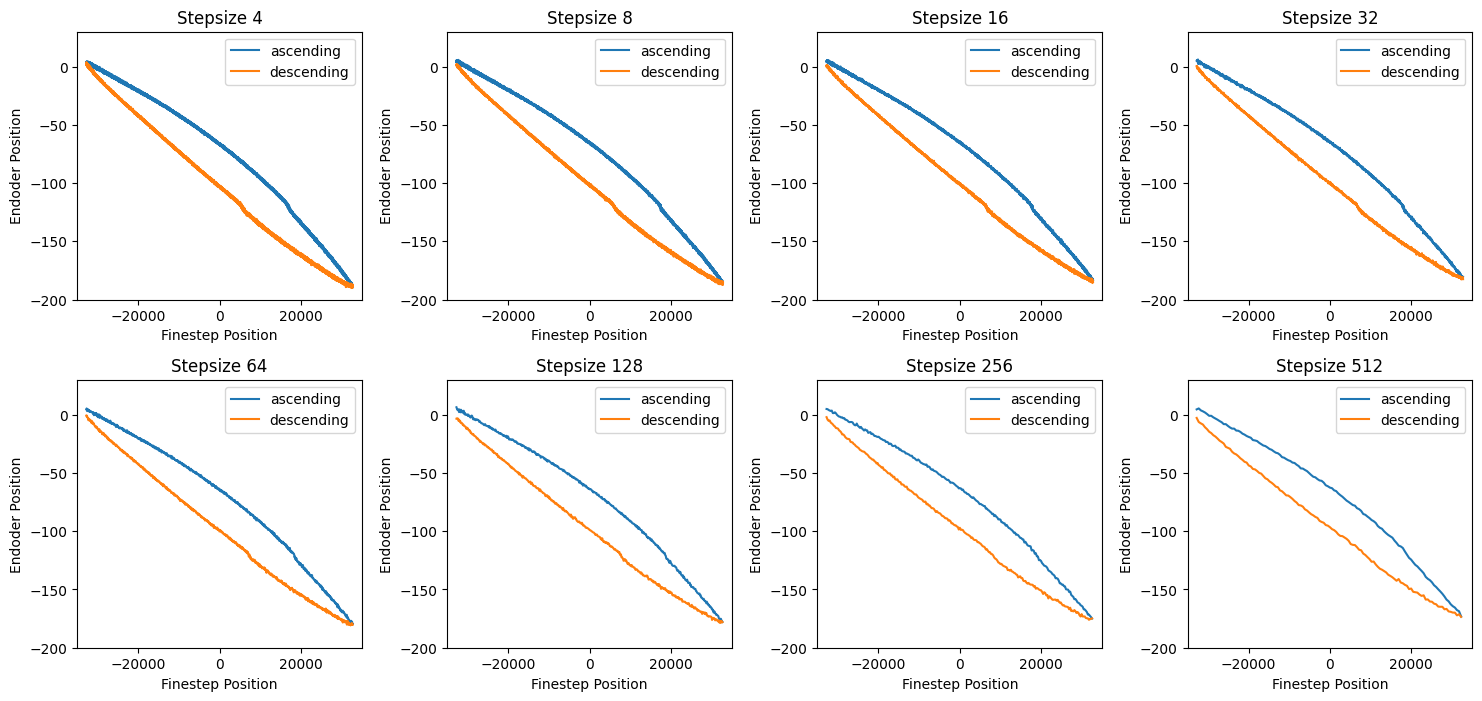

In [15]:
data = {}
for file in os.listdir('../dat/hysteresis/'):
    if file.startswith('fr') and file.endswith('.csv'):
        stepsize = file.split('_')[1].split('.')[0]
        data[stepsize] = pd.read_csv(f'../dat/hysteresis/{file}')

fig = plt.figure(figsize=(10, 10))

for i, (key, value) in enumerate(sorted(data.items(), key=lambda x: int(x[0]))):
    x_concat = pd.concat([value['finestep'], value['finestep'].iloc[::-1]])
    y_concat = pd.concat([value['ca_mean'], value['cd_mean'].iloc[::-1]])
    plt.plot(x_concat, y_concat.rolling(window=4).mean(), label=key)
plt.xlim(-35000, 35000)
plt.ylim(-200, 30)
plt.xlabel('Finestep Position')
plt.ylabel('Encoder Position')
plt.title("Hysteresis at full range with different stepsizes")
plt.legend()
plt.show()

fig, ax = plt.subplots(2, 4, figsize=(18, 8))
# set vspacing between subplots
plt.subplots_adjust(hspace=0.3)	
plt.subplots_adjust(wspace=0.3)
for i, (key, value) in enumerate(sorted(data.items(), key=lambda x: int(x[0]))):
    k = i % 4
    j = i // 4
    ax[j][k].plot(value['finestep'], value['ca_mean'], label='ascending')
    ax[j][k].plot(value['finestep'], value['cd_mean'], label='descending')
    ax[j][k].set_xlim(-35000, 35000)
    ax[j][k].set_ylim(-200, 30)
    ax[j][k].set_xlabel('Finestep Position')
    ax[j][k].set_ylabel('Endoder Position')
    ax[j][k].set_title("Stepsize " + key)
    ax[j][k].legend()

#### Hysteresis different ranges

In [6]:
iterations = 5
stepsize = 16
lower_bound = -np.power(2, 16-1)
upper_bound = np.power(2, 16-1) - 1
hysteresis = pd.DataFrame(columns=['finestep', 'counter', 'ascending', 'range_exponent', 'start', 'direction'])
directions = ['up', 'down']

reset(-np.power(2, 15).astype(int), 300)
for direction in directions:
    if direction == 'down':
        chill(upper_bound, 300)

    for i in range(iterations):
        sweep_range = np.power(2, 16-i)
        print(f'Sweep range: {sweep_range}')
        for j in range(np.power(2, 1+i)-1):
            start = max(int(lower_bound + j * sweep_range/2), lower_bound)
            end = min(int(start + sweep_range), upper_bound)
            
            chill(start, 120)
            if direction == 'down':
                start, end = end, start
                stepsize = -stepsize
            print(f'Start: {start}, End: {end}')
            
            for p in tqdm(range(start, end, stepsize)):
                nc.setFinePos16Bit('C', p)
                for _ in range(5):
                    hysteresis = hysteresis._append({'finestep': p,
                                                    'counter': nc.readCounter()['C'],
                                                    'ascending': True,
                                                    'range_exponent': 16-i,
                                                    'start': start,
                                                    'direction': direction}, ignore_index=True)
            for p in tqdm(range(end, start, -stepsize)):
                nc.setFinePos16Bit('C', p)
                for _ in range(5):
                    hysteresis = hysteresis._append({'finestep': p,
                                                    'counter': nc.readCounter()['C'],
                                                    'ascending': False,
                                                    'range_exponent': 16-i,
                                                    'start': start,
                                                    'direction': direction}, ignore_index=True)
            hysteresis.to_csv(f'../dat/hysteresis/hysteresis_part.csv')
hysteresis.to_csv(f'../dat/hysteresis/hysteresis.csv')



Sweep range: 65536
Start: -32768, End: 32767


100%|██████████| 4096/4096 [06:32<00:00, 10.43it/s]


Sweep range: 32768
Start: -32768, End: 0


100%|██████████| 2048/2048 [03:16<00:00, 10.42it/s]


Start: -16384, End: 16384


100%|██████████| 2048/2048 [03:16<00:00, 10.40it/s]


Start: 0, End: 32767


100%|██████████| 2048/2048 [03:16<00:00, 10.40it/s]


Sweep range: 16384
Start: -32768, End: -16384


100%|██████████| 1024/1024 [01:38<00:00, 10.41it/s]


Start: -24576, End: -8192


100%|██████████| 1024/1024 [01:38<00:00, 10.39it/s]


Start: -16384, End: 0


100%|██████████| 1024/1024 [01:38<00:00, 10.40it/s]


Start: -8192, End: 8192


100%|██████████| 1024/1024 [01:38<00:00, 10.39it/s]


Start: 0, End: 16384


100%|██████████| 1024/1024 [01:38<00:00, 10.40it/s]


Start: 8192, End: 24576


100%|██████████| 1024/1024 [01:38<00:00, 10.39it/s]


Start: 16384, End: 32767


100%|██████████| 1024/1024 [01:38<00:00, 10.38it/s]


Sweep range: 8192
Start: -32768, End: -24576


100%|██████████| 512/512 [00:49<00:00, 10.40it/s]


Start: -28672, End: -20480


100%|██████████| 512/512 [00:49<00:00, 10.36it/s]


Start: -24576, End: -16384


100%|██████████| 512/512 [00:49<00:00, 10.39it/s]


Start: -20480, End: -12288


100%|██████████| 512/512 [00:49<00:00, 10.40it/s]


Start: -16384, End: -8192


100%|██████████| 512/512 [00:49<00:00, 10.34it/s]


Start: -12288, End: -4096


100%|██████████| 512/512 [00:49<00:00, 10.33it/s]


Start: -8192, End: 0


100%|██████████| 512/512 [00:49<00:00, 10.30it/s]


Start: -4096, End: 4096


100%|██████████| 512/512 [00:50<00:00, 10.23it/s]


Start: 0, End: 8192


100%|██████████| 512/512 [00:50<00:00, 10.12it/s]


Start: 4096, End: 12288


100%|██████████| 512/512 [00:52<00:00,  9.76it/s]


Start: 8192, End: 16384


100%|██████████| 512/512 [00:56<00:00,  9.02it/s]


Start: 12288, End: 20480


100%|██████████| 512/512 [01:03<00:00,  8.10it/s]


Start: 16384, End: 24576


100%|██████████| 512/512 [01:12<00:00,  7.10it/s]


Start: 20480, End: 28672


100%|██████████| 512/512 [01:19<00:00,  6.48it/s]


Start: 24576, End: 32767


100%|██████████| 512/512 [01:23<00:00,  6.14it/s]


Sweep range: 4096
Start: -32768, End: -28672


100%|██████████| 256/256 [00:43<00:00,  5.91it/s]


Start: -30720, End: -26624


100%|██████████| 256/256 [00:42<00:00,  5.96it/s]


Start: -28672, End: -24576


100%|██████████| 256/256 [00:43<00:00,  5.91it/s]


Start: -26624, End: -22528


100%|██████████| 256/256 [00:43<00:00,  5.83it/s]


Start: -24576, End: -20480


100%|██████████| 256/256 [00:44<00:00,  5.78it/s]


Start: -22528, End: -18432


100%|██████████| 256/256 [00:44<00:00,  5.73it/s]


Start: -20480, End: -16384


100%|██████████| 256/256 [00:44<00:00,  5.72it/s]


Start: -18432, End: -14336


100%|██████████| 256/256 [00:44<00:00,  5.71it/s]


Start: -16384, End: -12288


100%|██████████| 256/256 [00:44<00:00,  5.69it/s]


Start: -14336, End: -10240


100%|██████████| 256/256 [00:45<00:00,  5.68it/s]


Start: -12288, End: -8192


100%|██████████| 256/256 [00:45<00:00,  5.69it/s]


Start: -10240, End: -6144


100%|██████████| 256/256 [00:45<00:00,  5.67it/s]


Start: -8192, End: -4096


100%|██████████| 256/256 [00:45<00:00,  5.68it/s]


Start: -6144, End: -2048


100%|██████████| 256/256 [00:45<00:00,  5.68it/s]


Start: -4096, End: 0


100%|██████████| 256/256 [00:45<00:00,  5.67it/s]


Start: -2048, End: 2048


100%|██████████| 256/256 [00:45<00:00,  5.68it/s]


Start: 0, End: 4096


100%|██████████| 256/256 [00:45<00:00,  5.68it/s]


Start: 2048, End: 6144


100%|██████████| 256/256 [00:45<00:00,  5.68it/s]


Start: 4096, End: 8192


100%|██████████| 256/256 [00:45<00:00,  5.68it/s]


Start: 6144, End: 10240


100%|██████████| 256/256 [00:45<00:00,  5.68it/s]


Start: 8192, End: 12288


100%|██████████| 256/256 [00:45<00:00,  5.63it/s]


Start: 10240, End: 14336


100%|██████████| 256/256 [00:45<00:00,  5.67it/s]


Start: 12288, End: 16384


100%|██████████| 256/256 [00:45<00:00,  5.67it/s]


Start: 14336, End: 18432


100%|██████████| 256/256 [00:45<00:00,  5.67it/s]


Start: 16384, End: 20480


100%|██████████| 256/256 [00:45<00:00,  5.67it/s]


Start: 18432, End: 22528


100%|██████████| 256/256 [00:45<00:00,  5.68it/s]


Start: 20480, End: 24576


100%|██████████| 256/256 [00:45<00:00,  5.68it/s]


Start: 22528, End: 26624


100%|██████████| 256/256 [00:45<00:00,  5.68it/s]


Start: 24576, End: 28672


100%|██████████| 256/256 [00:45<00:00,  5.67it/s]


Start: 26624, End: 30720


100%|██████████| 256/256 [00:45<00:00,  5.67it/s]


Start: 28672, End: 32767


100%|██████████| 256/256 [00:45<00:00,  5.68it/s]


Sweep range: 65536
Start: 32767, End: -32768


100%|██████████| 4096/4096 [12:01<00:00,  5.68it/s]


Sweep range: 32768
Start: 0, End: -32768


0it [00:00, ?it/s]
0it [00:00, ?it/s]


In [18]:
from scipy.stats import norm
def weighted_mean(group, std_dev):
    mean = group['counter'].mean()
    weights = norm.pdf(group['counter'], loc=mean, scale=std_dev)
    return np.average(group['counter'], weights=weights)

In [5]:
df = pd.read_csv('../dat/hysteresis/hysteresis_up.csv', index_col=0)
#df_weighted_mean = df.groupby(['ascending', 'finestep', 'range_exponent', 'start', 'direction']).apply(weighted_mean, std_dev=1.4073375618956234).reset_index()
#df_weighted_mean.rename(columns={0: 'counter'}, inplace=True)
df_mean = df.groupby(['ascending', 'finestep', 'range_exponent', 'start', 'direction']).aggregate({'counter': 'mean'}).reset_index()

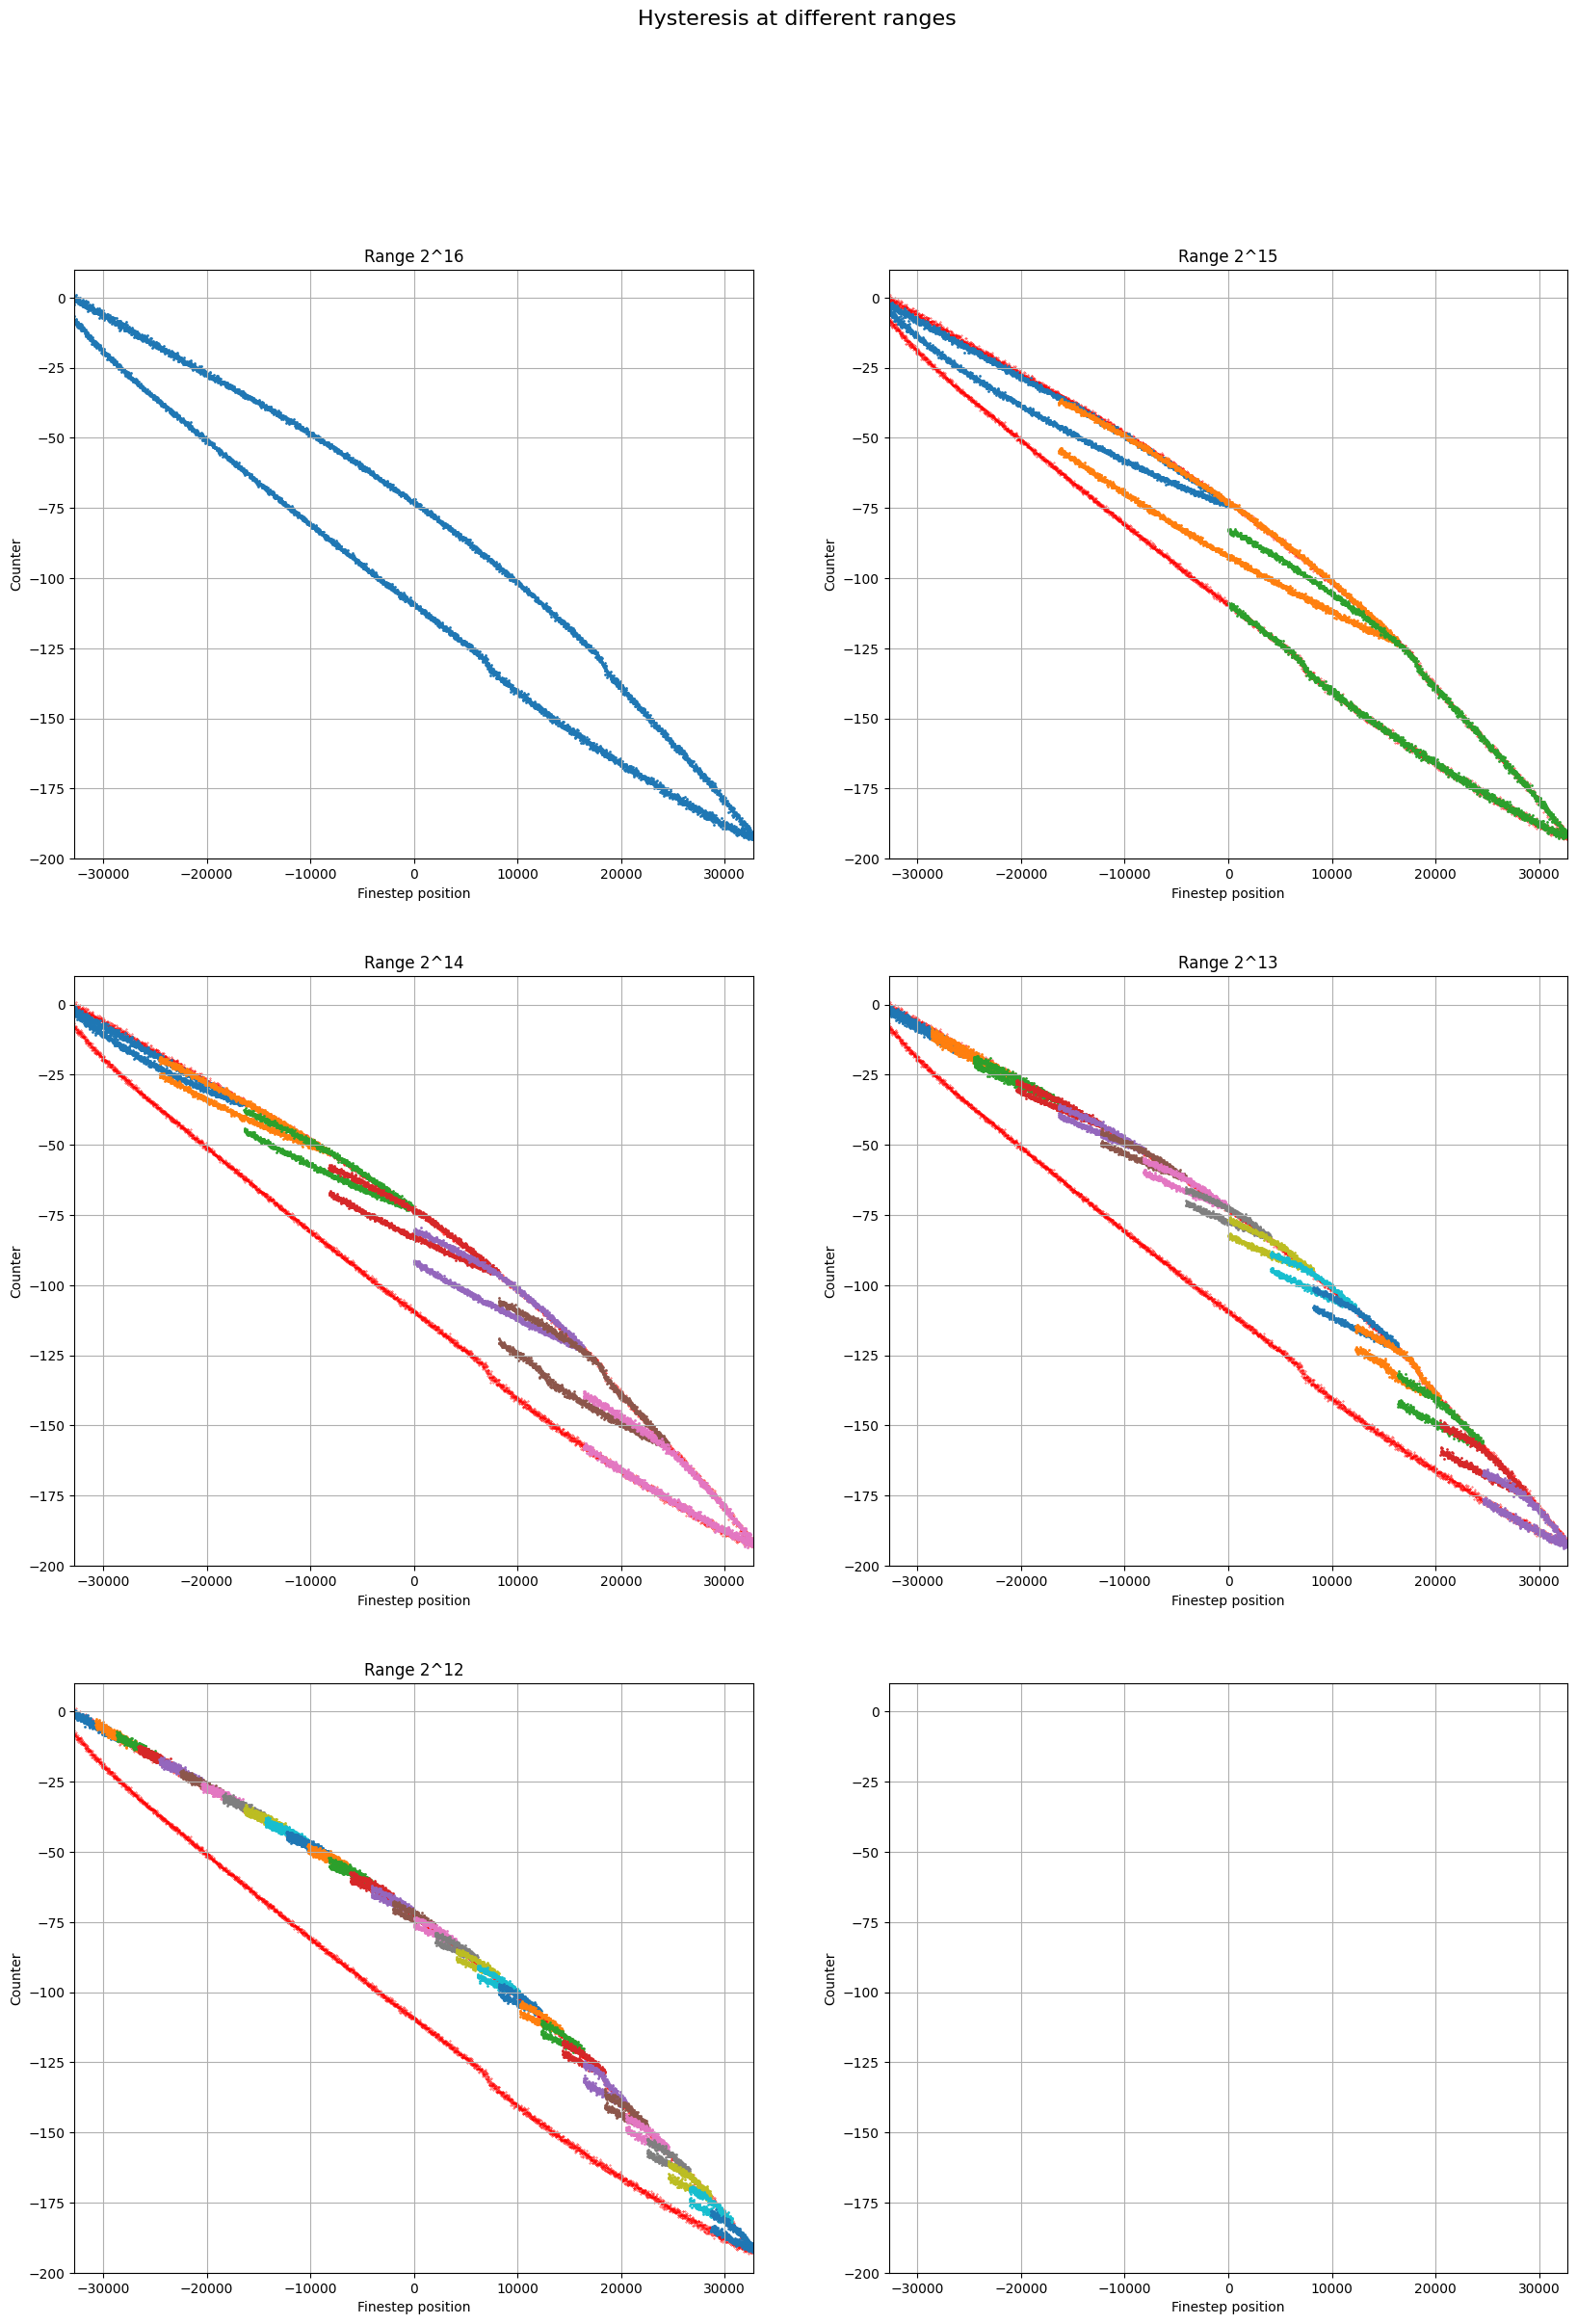

In [6]:
df_plot = df_mean

fig, ax = plt.subplots(3, 2, figsize=(20, 27))

plt.suptitle('Hysteresis at different ranges', fontsize=16)

range16 = df_plot[(df_plot['range_exponent'] == 16) & (df_plot['direction'] == 'up')]
ax[0, 0].scatter(range16['finestep'], range16['counter'], label='Range 2^16', s=1)
ax[0, 0].set_title('Range 2^16')
ax[0, 1].scatter(range16['finestep'], range16['counter'], label='Range 2^16', s=0.1, color='red')
ax[0, 1].set_title('Range 2^16')
ax[1, 0].scatter(range16['finestep'], range16['counter'], label='Range 2^16', s=0.1, color='red')
ax[1, 1].scatter(range16['finestep'], range16['counter'], label='Range 2^16', s=0.1, color='red')
ax[2, 0].scatter(range16['finestep'], range16['counter'], label='Range 2^16', s=0.1, color='red')



range15 = df_plot[df_plot['range_exponent'] == 15]
for v in range15['start'].unique():
    dat = range15[range15['start'] == v]
    ax[0, 1].scatter(dat['finestep'], dat['counter'], label='Range 2^15', s=1)
ax[0, 1].set_title('Range 2^15')

range14 = df_plot[df_plot['range_exponent'] == 14]
for v in range14['start'].unique():
    dat = range14[range14['start'] == v]
    ax[1, 0].scatter(dat['finestep'], dat['counter'], label='Range 2^14', s=1)
ax[1, 0].set_title('Range 2^14')

range13 = df_plot[df_plot['range_exponent'] == 13]
for v in range13['start'].unique():
    dat = range13[range13['start'] == v]
    ax[1, 1].scatter(dat['finestep'], dat['counter'], label='Range 2^13', s=1)
ax[1, 1].set_title('Range 2^13')

range12 = df_plot[df_plot['range_exponent'] == 12]
for v in range12['start'].unique():
    dat = range12[range12['start'] == v]
    ax[2, 0].scatter(dat['finestep'], dat['counter'], label='Range 2^12', s=1)
ax[2, 0].set_title('Range 2^12')

for ax in ax.flatten():
    ax.set_xlim(-np.power(2,15), np.power(2,15))
    ax.set_ylim(-200, 10)
    ax.set_xlabel('Finestep position')
    ax.set_ylabel('Counter')
    ax.grid(True)


In [60]:
lower_bound = -np.power(2, 16-1)
upper_bound = np.power(2, 16-1)
interval = np.power(2, 12)
points = range(lower_bound, upper_bound+1, interval)
stepsize = 16

hysteresis = pd.DataFrame(columns=['finestep', 'counter', 'ascending', 'range_exponent', 'start', 'direction'])


print(list(points))

# start from the middle, then go one step to the right, then go one step to the left
start = 0
middle = len(points) // 2
ascending = True
for i in range(1, len(points) // 2 + 1):
    goal = points[middle+i] if ascending else points[middle-i]
    goal = max(min(goal, upper_bound-1), lower_bound)
    print(f'Start: {start}, Goal: {goal}')
    direction = 'up' if ascending else 'down'

    if ascending:
        for p in tqdm(range(start, goal, stepsize)):
                    nc.setFinePos16Bit('C', p)
                    counter = 0
                    for _ in range(5):
                        counter += int(nc.readCounter()['C'])
                    counter /= 5
                    hysteresis = hysteresis._append({'finestep': p,
                                                    'counter': counter,
                                                    'ascending': False,
                                                    'range_exponent': 16-i,
                                                    'start': start,
                                                    'direction': direction}, ignore_index=True)
    else:
        for p in tqdm(range(start, goal, -stepsize)):
                    nc.setFinePos16Bit('C', p)
                    counter = 0
                    for _ in range(5):
                        counter += int(nc.readCounter()['C'])
                    counter /= 5
                    hysteresis = hysteresis._append({'finestep': p,
                                                    'counter': counter,
                                                    'ascending': False,
                                                    'range_exponent': 16-i,
                                                    'start': start,
                                                    'direction': direction}, ignore_index=True)
    hysteresis.to_csv(f'../dat/hysteresis/hysteresis_display.csv')

    ascending = not ascending

    start = goal


# fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# plt.suptitle('Hysteresis at different ranges', fontsize=16)
# # plot the range points
# for i in points:
#     ax.scatter(i, 0, s=10, color='red')
# ax.set_xlim(-np.power(2, 15), np.power(2, 15))
# plt.show()



[-32768, -28672, -24576, -20480, -16384, -12288, -8192, -4096, 0, 4096, 8192, 12288, 16384, 20480, 24576, 28672, 32768]
Start: 0, Goal: 4096


  0%|          | 0/256 [00:00<?, ?it/s]C:\Users\PC-255-DAVID\AppData\Local\Temp\ipykernel_7888\2446230358.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hysteresis = hysteresis._append({'finestep': p,
100%|██████████| 256/256 [00:24<00:00, 10.44it/s]


Start: 4096, Goal: -8192


100%|██████████| 768/768 [01:13<00:00, 10.44it/s]


Start: -8192, Goal: 12288


100%|██████████| 1280/1280 [02:02<00:00, 10.44it/s]


Start: 12288, Goal: -16384


100%|██████████| 1792/1792 [02:51<00:00, 10.44it/s]


Start: -16384, Goal: 20480


100%|██████████| 2304/2304 [03:40<00:00, 10.44it/s]


Start: 20480, Goal: -24576


100%|██████████| 2816/2816 [04:29<00:00, 10.44it/s]


Start: -24576, Goal: 28672


100%|██████████| 3328/3328 [05:18<00:00, 10.44it/s]


Start: 28672, Goal: -32768


100%|██████████| 3840/3840 [06:07<00:00, 10.44it/s]


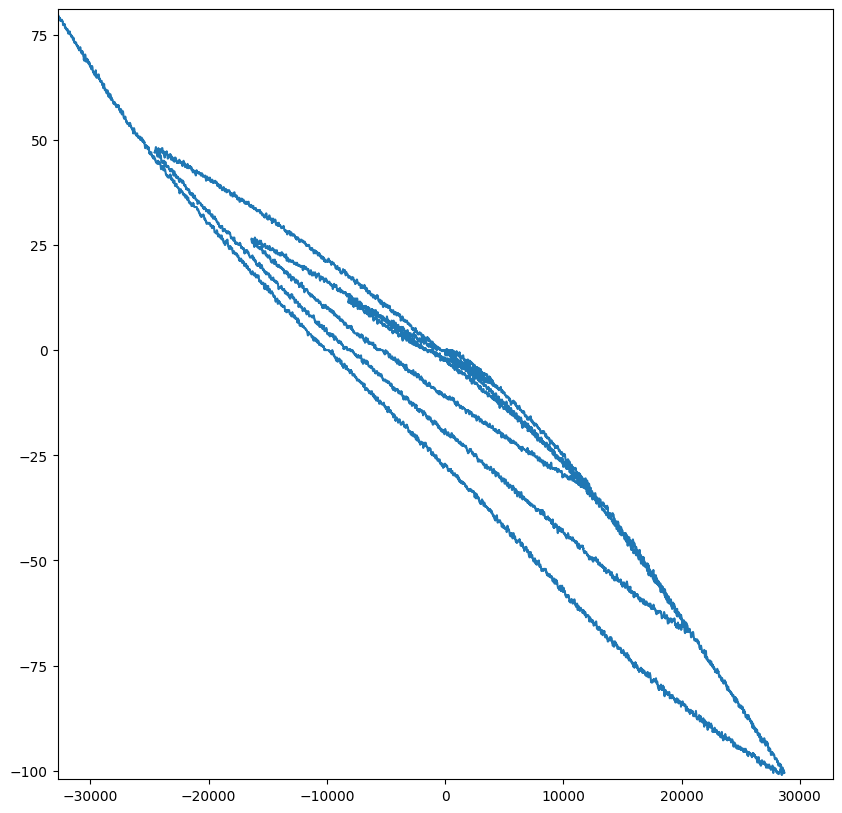

In [63]:
dat = hysteresis
dat['counter'] = dat['counter'].astype(int)
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(dat['finestep'], dat['counter'].rolling(4).mean())
ax.set_xlim(-np.power(2, 15), np.power(2, 15))
ax.set_ylim(min(dat['counter']), max(dat['counter']))

plt.show()

In [59]:
nc.setFinePos16Bit('C', 0)
nc.resetCounter()

''